In [1]:
from datasets import getCilia
from torchvision import transforms
from torch.utils import data
from utils import joint_transforms
from utils import training_utils
import torch.nn as nn
from models import tiramisu
import torchvision
from imageio import imwrite
from imageio import imread
import torch
import matplotlib.pyplot as plt
import time
from pathlib import Path
import os

In [2]:
## check PyTorch GPU support
try: 
    if torch.cuda.get_device_name(0):
        print ('Your GPU is {}'.format(torch.cuda.get_device_name(0)))
except AttributeError:
    print ('No GPU found!')

No GPU found!


In [3]:
# Specify the path for folder
# ROOT = '/media/data2TB/jeremyshi/data/cilia/'
ROOT = '/Volumes/Samsung USB/data/cilia/'

# Joint_tranformation for training inputs and targets
train_joint_transformer = joint_transforms.Compose([
    joint_transforms.RandomSizedCrop(256),
    joint_transforms.RandomHorizontallyFlip()
    ])

# Tranformation for training inputs and targets (change them to tensors)
img_transform = transforms.Compose([
    transforms.ToTensor()
    ])

cilia = getCilia.CiliaData(ROOT,
    joint_transform = train_joint_transformer,
    input_transform = img_transform,
    target_transform = img_transform)

In [4]:
# Load the training data into PyTorch
train_loader = data.DataLoader(cilia, batch_size=1, shuffle=True)

In [5]:
# Check the input and target images
input_a, target_a = next(iter(train_loader))
print (input_a.size(), target_a.size())

torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])


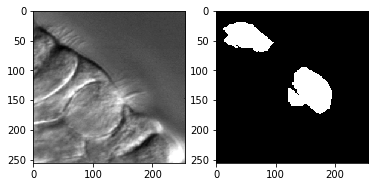

In [6]:
# Plot the ground truth for training
figure, subplot = plt.subplots(1,2)
subplot[0].imshow(input_a[0, 0, :, :], cmap='gray')
subplot[1].imshow(target_a[0, :, :], cmap='gray')

In [7]:
# Seems that PyTorch dataloader automatically changes the range to (0,1) after calling ToTensor()
input_a[0, 0, :, :], target_a[0, :, :]

(
  0.5961  0.5961  0.5961  ...   0.4627  0.4706  0.4745
  0.5922  0.5922  0.5922  ...   0.4784  0.4706  0.4667
  0.5882  0.5922  0.6000  ...   0.4745  0.4706  0.4627
           ...             ⋱             ...          
  0.8353  0.8353  0.8392  ...   0.7373  0.7216  0.7059
  0.8471  0.8549  0.8627  ...   0.7176  0.6980  0.6863
  0.8510  0.8706  0.8941  ...   0.7059  0.6824  0.6667
 [torch.FloatTensor of size 256x256], 
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
        ...          ⋱          ...       
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
 [torch.LongTensor of size 256x256])

## Training

In [8]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 3000
torch.cuda.manual_seed(0)

In [9]:
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.apply(training_utils.weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss().cuda()

In [10]:
# Load the valiation set
val_cilia = getCilia.CiliaData(ROOT, 'validate',
                  joint_transform = None, 
                  input_transform=img_transform,
                  target_transform=img_transform
                 )

val_loader = torch.utils.data.DataLoader(
                val_cilia, batch_size=1, shuffle=True)

In [9]:
# check (and build) the saved path for storing the results.

RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)

In [ ]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = training_utils.train(
        model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err = training_utils.test(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    training_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    training_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 0.9533, Acc: 0.6255
Train Time 0m 15s
Val - Loss: 0.8745 | Acc: 0.6857
Total Time 0m 19s

Epoch 2
Train - Loss: 0.8194, Acc: 0.6723
Train Time 0m 16s
Val - Loss: 0.9246 | Acc: 0.6752
Total Time 0m 20s

Epoch 3
Train - Loss: 0.8243, Acc: 0.6693
Train Time 0m 16s
Val - Loss: 0.8863 | Acc: 0.6664
Total Time 0m 20s

Epoch 4
Train - Loss: 0.7654, Acc: 0.7023
Train Time 0m 16s
Val - Loss: 0.8764 | Acc: 0.6911
Total Time 0m 20s

Epoch 5
Train - Loss: 0.7528, Acc: 0.7085
Train Time 0m 15s
Val - Loss: 0.7267 | Acc: 0.7143
Total Time 0m 20s

Epoch 6
Train - Loss: 0.7335, Acc: 0.7181
Train Time 0m 15s
Val - Loss: 0.7611 | Acc: 0.7187
Total Time 0m 20s

Epoch 7
Train - Loss: 0.7383, Acc: 0.7141
Train Time 0m 16s
Val - Loss: 0.8544 | Acc: 0.7284
Total Time 0m 20s

Epoch 8
Train - Loss: 0.7280, Acc: 0.7178
Train Time 0m 15s
Val - Loss: 0.7448 | Acc: 0.7026
Total Time 0m 20s

Epoch 9
Train - Loss: 0.7017, Acc: 0.7295
Train Time 0m 15s
Val - Loss: 0.8167 | Acc: 0.7132
Total Time 

Epoch 74
Train - Loss: 0.4661, Acc: 0.8216
Train Time 0m 15s
Val - Loss: 0.8766 | Acc: 0.7430
Total Time 0m 19s

Epoch 75
Train - Loss: 0.4776, Acc: 0.8142
Train Time 0m 15s
Val - Loss: 0.6680 | Acc: 0.7647
Total Time 0m 19s

Epoch 76
Train - Loss: 0.4617, Acc: 0.8200
Train Time 0m 15s
Val - Loss: 0.8968 | Acc: 0.7561
Total Time 0m 19s

Epoch 77
Train - Loss: 0.4684, Acc: 0.8206
Train Time 0m 15s
Val - Loss: 1.0482 | Acc: 0.6932
Total Time 0m 19s

Epoch 78
Train - Loss: 0.4480, Acc: 0.8256
Train Time 0m 16s
Val - Loss: 0.8860 | Acc: 0.6869
Total Time 0m 20s

Epoch 79
Train - Loss: 0.4538, Acc: 0.8254
Train Time 0m 15s
Val - Loss: 1.0132 | Acc: 0.7211
Total Time 0m 19s

Epoch 80
Train - Loss: 0.4678, Acc: 0.8175
Train Time 0m 15s
Val - Loss: 1.0192 | Acc: 0.7338
Total Time 0m 20s

Epoch 81
Train - Loss: 0.4402, Acc: 0.8309
Train Time 0m 15s
Val - Loss: 1.1075 | Acc: 0.6312
Total Time 0m 19s

Epoch 82
Train - Loss: 0.4584, Acc: 0.8203
Train Time 0m 15s
Val - Loss: 0.8128 | Acc: 0.7332
To

In [ ]:
## To load a model

model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1).cuda()
model.load_state_dict(torch.load('/media/data2TB/jeremyshi/data/historicalweights/weights-2985-0.473-0.078.pth')['state_dict'])
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss().cuda()

In [11]:
# load testing set
test_cilia = getCilia.CiliaData(ROOT, 'test',
                  joint_transform = None, 
                  input_transform=img_transform
                 )


test_loader = torch.utils.data.DataLoader(
                test_cilia, batch_size=1, shuffle=False)
    

In [20]:
# write results
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results(model, pic)
    pred_img = pred[0, :, :]
    pred_img[pred_img == 1] = 0
#     np.savetxt( pred_img.numpy(), fmt='%i')
    imwrite('.results/' + test_dir[i] + '.png', pred_img.numpy().astype(np.uint8))
    

In [ ]:
# To load a model from CPU
model = tiramisu.FCDenseNet103(n_classes=3, in_channels=1)
model.load_state_dict(torch.load('/Users/yuanmingshi/Downloads/weights-468-0.567-0.073.pth',  map_location='cpu')['state_dict'])
test_dir = sorted(os.listdir(ROOT + 'test' + '/data/'))
for i, pic in enumerate(test_loader):
    pred = training_utils.get_test_results_cpu(model, pic)
    pred_img = pred[0, :, :]
    pred_img[pred_img == 1] = 0
    imwrite('.results/' + test_dir[i] + '.png', pred_img.numpy().astype(np.uint8))
    print (str(i) + 'th image done!')

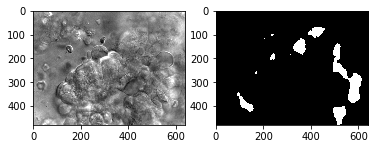

In [32]:
# Plot the ground truth for training
test_a = next(iter(test_loader))
test_res_a = imread('.results/' + test_dir[0] + '.png')
figure, subplot = plt.subplots(1,2)
subplot[0].imshow(test_a[0, 0, :, :], cmap='gray')
subplot[1].imshow(test_res_a, cmap='gray')